# Part 2: Create Strategy and Backtest

You are given the daily adjusted close price data of AAPL, MSFT, and TSLA on the trading days from January to June in prices.csv. You must create a trading strategy given your LLM-provided sentiment and then backtest and evaluate your strategy using this price data.

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

## Load Data

In [7]:
prices = pd.read_csv("prices.csv", parse_dates=["date"])
market_news = pd.read_csv("market_news.csv", parse_dates=["date"])


## Create Trading Signals

This is where you will translate the sentiment scores given from the LLM to buy/short/hold signals. This is up to you figure out how you want to do this.

**Make sure to avoid using future information (avoid look-ahead-bias)**

In [ ]:
# Merge prices pd with sentiment db, fill any missing data with 0 (hold position)
prices_long = prices.melt(id_vars=['date'], var_name='asset', value_name='adj_close')
df = pd.merge(prices_long, market_news[['date', 'asset', 'sentiment']], on=['date', 'asset'], how='left')
df['sentiment'] = df['sentiment'].fillna(0.0)

# We'll use a naive strategy where we go long when the sentiment is >0.5, short if its <-0.5, and hold otherwise
def get_signal(score):
    if score > 0.5:
        return 1 # Long
    elif score < -0.5:
        return -1 # Short
    else:
        return 0  # Hold
        
df['raw_signal'] = df['sentiment'].apply(get_signal)

# Avoid lookahead bias by shifting the signal by 1 day
df['position'] = df.groupby('asset')['raw_signal'].shift(1)
df['position'] = df['position'].fillna(0)

## Calculate Daily Returns of Strategy

In [18]:
df['asset_return'] = df.groupby('asset')['adj_close'].pct_change() #group by asset to prevent shenanigans
df['strategy_return'] = df['position'] * df['asset_return']

# Take mean across all strategies
portfolio = df.groupby('date')['strategy_return'].mean().to_frame('portfolio_return')
portfolio = portfolio.dropna()

# df

,date,asset,adj_close,sentiment,raw_signal,position,asset_return,strategy_return
0,2023-01-03,AAPL,123.211212,0.6,1,0.0,NaN,NaN
1,2023-01-04,AAPL,124.482040,0.8,1,1.0,0.010314,0.010314
2,2023-01-05,AAPL,123.161949,0.8,1,1.0,-0.010605,-0.010605
3,2023-01-06,AAPL,127.693581,0.7,1,1.0,0.036794,0.036794
4,2023-01-09,AAPL,128.215714,0.6,1,1.0,0.004089,0.004089
...,...,...,...,...,...,...,...,...
367,2023-06-26,TSLA,241.050003,0.8,1,0.0,-0.060600,-0.000000
368,2023-06-27,TSLA,250.210007,0.2,0,1.0,0.038000,0.038000
369,2023-06-28,TSLA,256.239990,0.1,0,0.0,0.024100,0.000000
370,2023-06-29,TSLA,257.500000,-0.4,0,0.0,0.004917,0.000000


## Calculate Performance Metrics

In [ ]:
# for calculating annual returns
TRADING_DAYS = 252

# Cumulative return
portfolio['cumulative_return'] = (1 + portfolio['portfolio_return']).cumprod()
total_return = portfolio['cumulative_return'].iloc[-1] - 1
volatility = portfolio['portfolio_return'].std() * np.sqrt(TRADING_DAYS)
sharpe_ratio = (portfolio['portfolio_return'].mean() / portfolio['portfolio_return'].std()) * np.sqrt(TRADING_DAYS)

cumulative = (1 + portfolio['portfolio_return']).cumprod()
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max
max_drawdown = drawdown.min()

In [21]:
print("===== BACKTEST RESULTS =====")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2%}")

===== BACKTEST RESULTS =====
Total Return: 26.34%
Annualized Volatility: 13.16%
Sharpe Ratio: 3.71
Max Drawdown: -3.90%


## Plot Return of Portfolio Compared to Benchmark

Create **two benchmarks** to compare your algorithm to. The first one should be the return of the three stocks (AAPL, MSFT, TSLA) over the given timeframe if you simply bought and held from the start. The second one should be the return of the S&P500 (SPY). You can obtain the necessary data for SPY using the Yahoo Finance API via the yfinance library.

In [ ]:
%pip install yfinance
import yfinance as yf

spy_data = yf.download(
    tickers="SPY",
    start="2023-01-02",
    end="2023-06-30",
    auto_adjust=True,
)

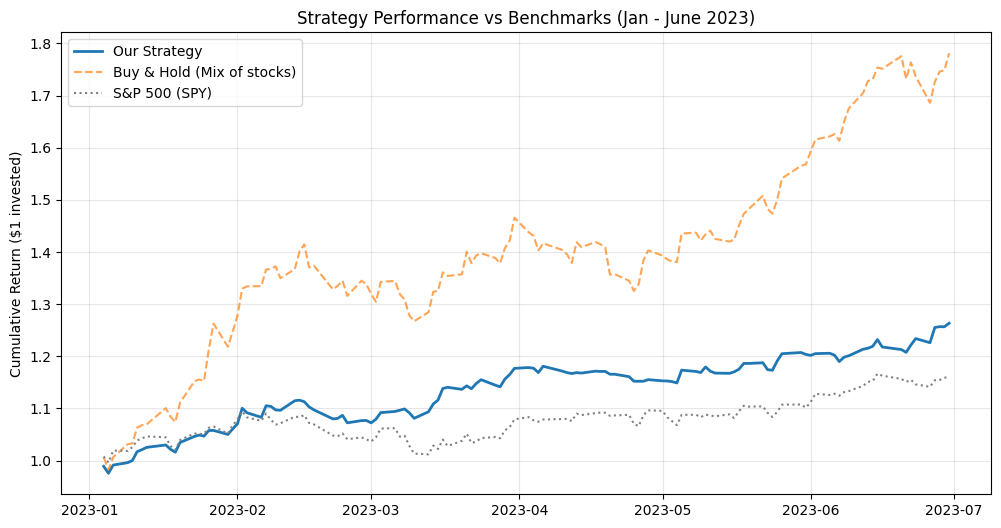

In [ ]:
bnh_returns = df.groupby('date')['asset_return'].mean().dropna()
bnh_cumulative = (1 + bnh_returns).cumprod()

# SPY
spy_data = yf.download(
    tickers="SPY",
    start="2023-01-01", # Use same timeframe
    end="2023-06-30",
    auto_adjust=True,
    progress=False
)['Close']

# Calculate SPY Returns
spy_returns = spy_data.pct_change().dropna()
spy_returns = spy_returns.reindex(portfolio.index).fillna(0)
spy_cumulative = (1 + spy_returns).cumprod()


plt.figure(figsize=(12, 6))
plt.plot(portfolio.index, portfolio['cumulative_return'], label='Our Strategy', linewidth=2)
plt.plot(bnh_cumulative.index, bnh_cumulative, label='Buy & Hold (Mix of stocks)', linestyle='--', alpha=0.7)
plt.plot(spy_cumulative.index, spy_cumulative, label='S&P 500 (SPY)', linestyle=':', color='gray')

plt.title('Strategy Performance vs Benchmarks (Jan - June 2023)')
plt.ylabel('Cumulative Return ($1 invested)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Calculate Relative Metrics

Calculate and print the following in comparison to **each** benchmark (i.e. you will have two values for each):
- The excess return over the benchmark (i.e. Alpha)
- The sensitivity compared to the benchmark (i.e. Beta)
- The risk-adjusted outperformance (i.e. Information Ratio)

In [52]:
def calculate_metrics(strategy_rets, benchmark_rets, benchmark_name):
    # Align data
    aligned = pd.DataFrame({'strat': strategy_rets.squeeze(), 'bench': benchmark_rets.squeeze()}).dropna()
    
    # Excess Returns
    excess_returns = aligned['strat'] - aligned['bench']
    
    # Alpha & Beta (Linear Regression)
    # y = alpha + beta * x
    covariance = np.cov(aligned['strat'], aligned['bench'])[0, 1]
    variance = np.var(aligned['bench'])
    
    beta = covariance / variance
    
    # Assume use of Jensen's Alpha
    # Alpha = Mean_Strat - Beta * Mean_Bench
    alpha = (aligned['strat'].mean() - beta * aligned['bench'].mean()) * TRADING_DAYS
    
    # Information Ratio (Annualized)
    # IR = Mean(Excess) / Std(Excess)
    ir = (excess_returns.mean() / excess_returns.std()) * np.sqrt(TRADING_DAYS)
    
    print(f"--- vs {benchmark_name} ---")
    print(f"Alpha (Annualized): {alpha:.2%}")
    print(f"Beta: {beta:.2f}")
    print(f"Information Ratio: {ir:.2f}")
    print("")

    # print(aligned)

calculate_metrics(portfolio['portfolio_return'], bnh_returns, "Buy & Hold (Stock Mix)")
calculate_metrics(portfolio['portfolio_return'], spy_returns, "S&P 500 (SPY)")

--- vs Buy & Hold (Stock Mix) ---
Alpha (Annualized): 7.89%
Beta: 0.33
Information Ratio: -3.50

--- vs S&P 500 (SPY) ---
Alpha (Annualized): 27.84%
Beta: 0.67
Information Ratio: 1.71

